In [1]:
import random
import time 
import os

import numpy as np
import pandas as pd
import seaborn as sn
from argparse import Namespace

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification, \
    get_linear_schedule_with_warmup, BertConfig

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    dataset = "lemmatized_filtered",
    models = ["SZTAKI-HLT/hubert-base-cc", "bert-base-multilingual-uncased"],
    model_save_dir = ".model_storage/BERT",
    model_state_file = "model",
    seed = 1234,
    num_epochs = 4,
    learning_rate = 5e-5,
    hidden_size = 100,
    batch_size = 16,
    cuda = True,
    train_column = 'long_question'
)

In [3]:
device = torch.device('cuda' if args.cuda & torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)

In [5]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/BERT directory already exists


In [6]:
args.dataset = os.path.join(args.dataset_dir, args.dataset_prefix + args.dataset)
print(args.dataset)

.data\faq_with_splits_lemmatized_filtered


In [7]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

In [8]:
tokenizers = {}

for model in args.models:
    tokenizers[model] = BertTokenizerFast.from_pretrained(model)

In [9]:
df = pd.read_csv(args.dataset + '.csv')

In [10]:
df.head()

,short_question,long_question,answer,main_category,sub_category,split
0,vállsérülés gyógytorna,vállsérülés gyógytorna az kérdés rossz váll sz...,"edzeni kénealapjába véve mindent váll, hát, tr...",Egészség,"Sérülések, balesetek",train
1,heti hányszor dehidtratálja szervezet citromos...,heti hányszor dehidtratálja szervezet citromos...,"Nem értem miért akarod magad dehidratálni, nem...",Egészség,Bio életmód,train
2,a doctor who ban vörös hajú lány,a doctor who ban vörös hajú lány,Vagy Amy Pond vagy Donna Noble,Szórakozás,"Filmek, sorozatok",train
3,vesz 2 törpenyuszi szob 4 5 honap gyávák ők sz...,vesz 2 törpenyuszi szob 4 5 honap gyávák ők sz...,Egy törpenyuszihoz nagyon sok türelem kell. Pr...,Állatok,Kisemlősök,train
4,fityma szűkület,fityma szűkület 15 éves fiú nyugalmi állapot p...,Valószínű. Esetleg még a fitymaféked lehet röv...,Egészség,Férfiak egészsége,train


In [11]:
df = df[['main_category', args.train_column, 'split']]

In [12]:
df.head()

,main_category,long_question,split
0,Egészség,vállsérülés gyógytorna az kérdés rossz váll sz...,train
1,Egészség,heti hányszor dehidtratálja szervezet citromos...,train
2,Szórakozás,a doctor who ban vörös hajú lány,train
3,Állatok,vesz 2 törpenyuszi szob 4 5 honap gyávák ők sz...,train
4,Egészség,fityma szűkület 15 éves fiú nyugalmi állapot p...,train


In [13]:
target_names = df.main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

print(target_names)
print(target_dict)

['Egészség', 'Szórakozás', 'Állatok', 'Számítástechnika']
{'Egészség': 0, 'Szórakozás': 1, 'Állatok': 2, 'Számítástechnika': 3}


In [14]:
df.main_category = df.main_category.apply(lambda x: target_dict[x])

In [15]:
max_seq_len = 128

In [16]:
def tokenize(df, tokenizer):
    return tokenizer.batch_encode_plus(
        df[args.train_column].tolist(),
        max_length = max_seq_len,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False
)

In [17]:
valid_df = df[df.split == 'val']
train_df = df[df.split == 'train']
test_df = df[df.split == 'test']

In [18]:
encoded_data = {}

for model in args.models:
    encoded_data[model] = {}
    tokenizer = tokenizers[model]
    encoded_data[model]['train'] = tokenize(train_df, tokenizer)
    encoded_data[model]['valid'] = tokenize(valid_df, tokenizer)
    encoded_data[model]['test'] = tokenize(test_df, tokenizer)

In [19]:
input_ids = {}
attention_masks = {}

for model in args.models:
    input_ids[model] = {}
    attention_masks[model] = {}
    
    for split in ['train', 'valid', 'test']:
        input_ids[model][split] = encoded_data[model][split]['input_ids']
        attention_masks[model][split] = encoded_data[model][split]['attention_mask']

In [20]:
labels = {}

labels['train'] = torch.tensor(train_df.main_category.values)
labels['valid'] = torch.tensor(valid_df.main_category.values)
labels['test'] = torch.tensor(test_df.main_category.values)

In [21]:
datasets = {}

for model in args.models:
    datasets[model] = {}
    
    for split in ['train', 'valid', 'test']:
        datasets[model][split] = TensorDataset(
            torch.tensor(input_ids[model][split]),
            torch.tensor(attention_masks[model][split]),
            labels[split]
        )

In [22]:
dataloaders = {}

for model in args.models:
    dataloaders[model] = {}
    for split in ['train', 'valid', 'test']:
        dataloaders[model][split] = DataLoader(
            datasets[model][split],
            sampler=RandomSampler(datasets[model][split]),
            batch_size=args.batch_size
        )

In [23]:
class_wts = compute_class_weight('balanced', np.unique(train_df.main_category), \
                                 train_df.main_category)

print(class_wts)

[0.7529209  1.05188476 0.82005859 1.99306534]


C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=0         0
1         0
2         1
3         2
4         0
         ..
153550    1
153551    0
153552    0
153553    2
153555    3
Name: main_category, Length: 107490, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [24]:
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

In [25]:
def class_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(y_true=labels_flat, y_pred=preds_flat)  

In [26]:
def show_data_to_model(model, optimizer, scheduler, criterion, bar, train):
    epoch_loss = 0
    epoch_acc = 0
       
    total_predicted = []
    true_vals = []
    idx = 0

    for batch in bar:
        idx += 1
        if train:
            optimizer.zero_grad()
            model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }
        
        outputs = model(**inputs)
        
        logits = outputs[1]
        label_ids = inputs['labels'].cpu().numpy()

        loss = criterion(logits, batch[2])
        logits = logits.detach().cpu().numpy()
        acc = class_accuracy(logits, label_ids)

        total_predicted += np.argmax(logits, axis=1).flatten().tolist()
        true_vals += label_ids.flatten().tolist()

        if train:
            loss.backward()
            optimizer.step()
            scheduler.step()

        del batch
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
        epoch_loss += loss.item()
        epoch_acc += acc.item()
       
        bar.set_postfix(loss=(epoch_loss / idx), acc=(epoch_acc / idx))

    return epoch_loss / idx , epoch_acc / idx, total_predicted, true_vals

In [27]:
def train_model(model, optimizer, scheduler, criterion, bar):
    model.train()
    loss, acc, _, _ = show_data_to_model(model, optimizer, scheduler, criterion, bar, True)
    
    return loss, acc

In [28]:
def evaluate_model(model, optimizer, scheduler, criterion, bar):
    model.eval()
    with torch.no_grad():
        loss, acc, pred, true_vals = show_data_to_model(model, optimizer, scheduler, criterion, bar, False)
            
    return loss, acc, pred, true_vals

In [29]:
from transformers import logging
logging.set_verbosity_error()

In [30]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

models = {}

for model_ in args.models:
    start_time = int(time.time() * 1000)
    
    best_valid_loss = float('inf')
    
    train_losses[model_] = []
    train_accuracies[model_] = []

    valid_losses[model_] = []
    valid_accuracies[model_] = []
    
    train_dl = dataloaders[model_]['train']
    valid_dl = dataloaders[model_]['valid']    
        
    model = BertForSequenceClassification.from_pretrained(
        model_,
        num_labels = len(target_names),
        output_attentions=False,
        output_hidden_states=False   
    )
        
    optimizer = AdamW(
        model.parameters(),
        args.learning_rate,
        eps=1e-8
    )
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_dl) * args.num_epochs
    )
    
    criterion = CrossEntropyLoss(weight=weights)
    
    model = model.to(device)
    criterion = criterion.to(device)
   
    epoch_bar = tqdm(desc=f"'{model_}' epoch", total=args.num_epochs, position=0, leave=True)
        
    for epoch in range(args.num_epochs):
        train_bar = tqdm(train_dl, desc=f"'{model_}' train", leave=False)
        valid_bar = tqdm(valid_dl, desc=f"'{model_}' valid", leave=False)

        train_loss, train_acc = train_model(model, optimizer, scheduler, criterion, train_bar)
        valid_loss, valid_acc, _, _ = evaluate_model(model, optimizer, scheduler, criterion, valid_bar)

        train_losses[model_].append(train_loss)
        train_accuracies[model_].append(train_acc)

        valid_losses[model_].append(valid_loss)
        valid_accuracies[model_].append(valid_acc)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
     
            torch.save(model.state_dict(), args.model_state_file + "_" + model_.replace('/', '_') + ".pth")
 
        epoch_bar.update()
    models[model_] = model.to(torch.device('cpu'))


'SZTAKI-HLT/hubert-base-cc' epoch:   0%|          | 0/4 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'SZTAKI-HLT/hubert-base-cc' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' epoch:   0%|          | 0/4 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' train:   0%|          | 0/6719 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' valid:   0%|          | 0/1440 [00:00<?, ?it/s]

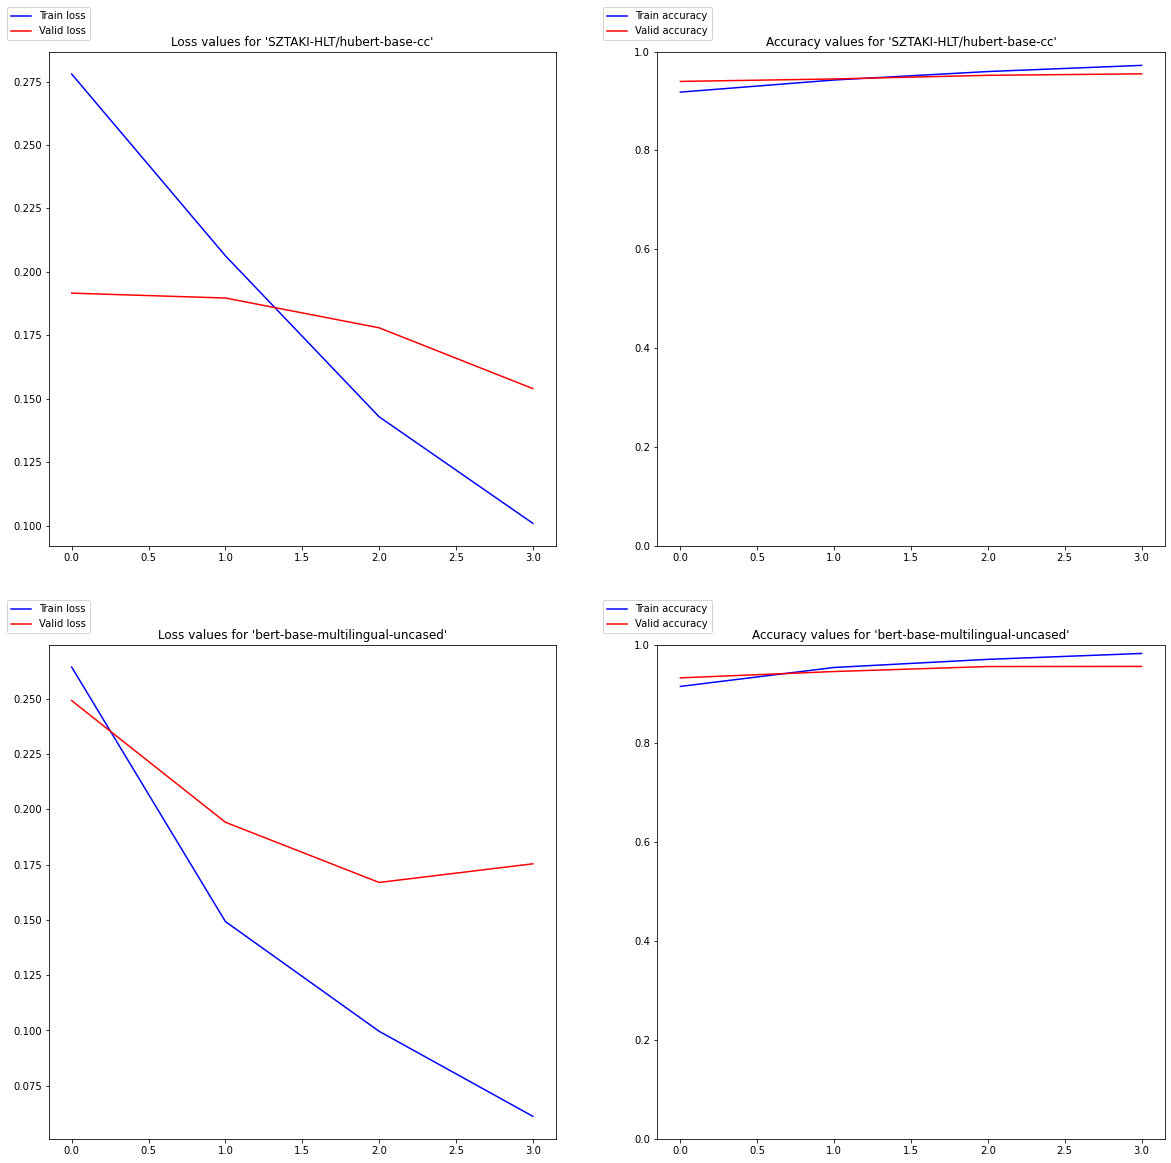

In [31]:
fig, axs = plt.subplots(len(args.models), 2, figsize=(10 * 2, 10 * len(args.models)))

for idx, model_ in enumerate(args.models):
    axs[idx, 0].set_title(f"Loss values for '{model_}'")
    axs[idx, 0].plot([*range(args.num_epochs)], train_losses[model_], color = 'b', label='Train loss')
    axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[model_], color = 'r', label='Valid loss')
    axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
    axs[idx, 1].set_title(f"Accuracy values for '{model_}'")
    axs[idx, 1].axis(ymin = 0, ymax = 1)
    axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[model_], color = 'b', label='Train accuracy')
    axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[model_], color = 'r', label='Valid accuracy')
    axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [32]:
predictions = {}
test_target = {}

for model_ in args.models:
    test_target[model_] = []
    test_dl = dataloaders[model_]['test']

    config = BertConfig.from_pretrained(model_)
    config.num_labels = len(target_names)
    config.output_attentions = False
    config.output_hidden_states = False
    
    model = models[model_]
    model.load_state_dict(torch.load(args.model_state_file + "_" + model_.replace('/', '_') + ".pth"))

    criterion = CrossEntropyLoss(weight=weights)
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    test_bar = tqdm(test_dl, desc=f"'{model_}' test", leave=False)

    _, _, predictions[model_], test_target[model_] = evaluate_model(model, None, None, criterion, test_bar)


'SZTAKI-HLT/hubert-base-cc' test:   0%|          | 0/1440 [00:00<?, ?it/s]

'bert-base-multilingual-uncased' test:   0%|          | 0/1440 [00:00<?, ?it/s]

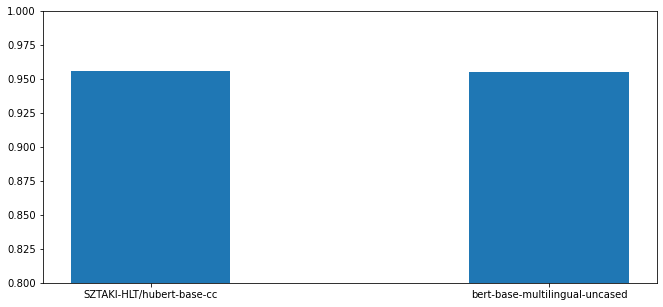

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
accuracy_scores = []

for model_ in args.models:
    pred = predictions[model_]
       
    accuracy_scores.append(accuracy_score(test_target[model_], pred))
    
ax.axis(ymin = 0.80, ymax = 1)
ax.bar(args.models, accuracy_scores, width=0.4)

plt.show()

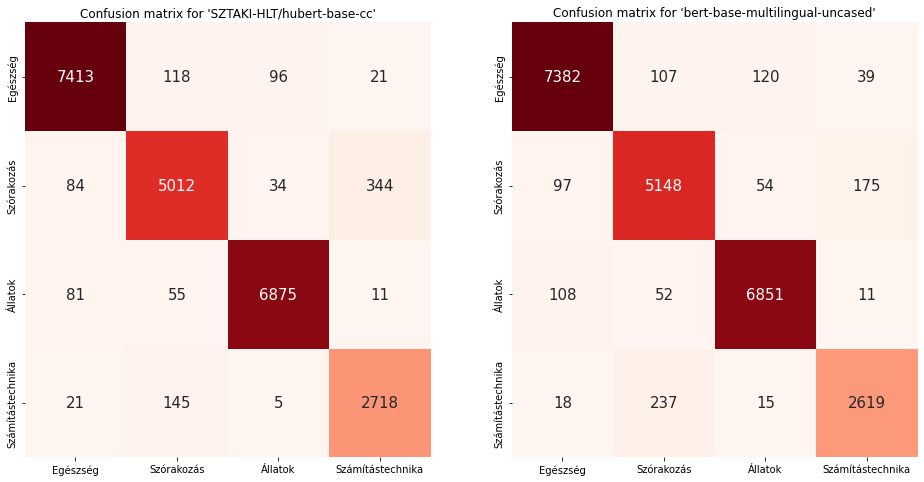

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4 * len(args.models)))

for idx, model_ in enumerate(args.models):
    axs[idx % 2].set_title(f"Confusion matrix for '{model_}'")
    
    pred = predictions[model_]
    
    cm = confusion_matrix(test_target[model_], pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
    heatmap = sn.heatmap(cm_df, annot=True, ax=axs[idx % 2], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [35]:
for model_ in args.models:
    pred = predictions[model_]
    report = classification_report(test_target[model_], pred, target_names=target_names)
    print(f"Classification report for '{model_}':\n{report}\n{'=' * 60}")

Classification report for 'SZTAKI-HLT/hubert-base-cc':
                  precision    recall  f1-score   support

        Egészség       0.98      0.97      0.97      7648
      Szórakozás       0.94      0.92      0.93      5474
         Állatok       0.98      0.98      0.98      7022
Számítástechnika       0.88      0.94      0.91      2889

        accuracy                           0.96     23033
       macro avg       0.94      0.95      0.95     23033
    weighted avg       0.96      0.96      0.96     23033

Classification report for 'bert-base-multilingual-uncased':
                  precision    recall  f1-score   support

        Egészség       0.97      0.97      0.97      7648
      Szórakozás       0.93      0.94      0.93      5474
         Állatok       0.97      0.98      0.97      7022
Számítástechnika       0.92      0.91      0.91      2889

        accuracy                           0.96     23033
       macro avg       0.95      0.95      0.95     23033
    weight